First of all, we create a stickman with 4 limbs which are arbitratily active to simulate our body in a simplist way.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

{'left_arm': 56.64245640916812,
 'right_arm': 67.46241437803118,
 'left_leg': 164.79385051571697,
 'right_leg': 8.789780838365823}

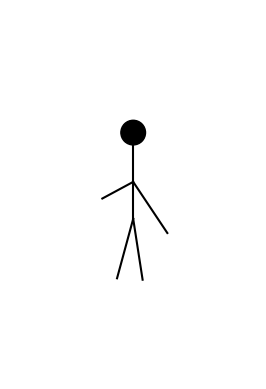

In [3]:
def genbody():
    def draw_stickman(ax, head_coords, limb_lengths, angles):
        """
       Draw a stickman on the given axis.

        Parameters:
        - ax: Matplotlib axis to draw on.
        - head_coords: Coordinates of the head (x, y).
        - limb_lengths: Dictionary with lengths of limbs (arms and legs).
        - angles: Dictionary with angles (in degrees) of limbs.
        """
        def get_limb_coords(start, length, angle):
            return (start[0] + length * np.cos(np.radians(angle)),
                    start[1] + length * np.sin(np.radians(angle)))

        # Draw the head
        head_radius = 0.5
        head_circle = plt.Circle(head_coords, head_radius, fill=True, color='black')
        ax.add_artist(head_circle)
    
        # Body (from head center to body center)
        body_length = limb_lengths['body']
        body_bottom = (head_coords[0], head_coords[1] - (head_radius + body_length))
        ax.plot([head_coords[0], body_bottom[0]], [head_coords[1], body_bottom[1]], 'k-')
    
        # Arms
        left_arm_angle = angles['left_arm']
        right_arm_angle = angles['right_arm']
        left_arm_end = get_limb_coords(body_bottom, limb_lengths['arm'], left_arm_angle + 90)
        right_arm_end = get_limb_coords(body_bottom, limb_lengths['arm'], right_arm_angle - 90)
        ax.plot([body_bottom[0], left_arm_end[0]], [body_bottom[1] + 1.5, left_arm_end[1]], 'k-')
        ax.plot([body_bottom[0], right_arm_end[0]], [body_bottom[1] + 1.5, right_arm_end[1]], 'k-')
    
        # Legs
        left_leg_angle = angles['left_leg']
        right_leg_angle = angles['right_leg']
        left_leg_end = get_limb_coords(body_bottom, limb_lengths['leg'], left_leg_angle + 90)
        right_leg_end = get_limb_coords(body_bottom, limb_lengths['leg'], right_leg_angle - 90)
        ax.plot([body_bottom[0], left_leg_end[0]], [body_bottom[1], left_leg_end[1]], 'k-')
        ax.plot([body_bottom[0], right_leg_end[0]], [body_bottom[1], right_leg_end[1]], 'k-')

    def generate_random_angles():
        return {
            'left_arm': np.random.uniform(30, 145),
            'right_arm': np.random.uniform(30, 145),
            'left_leg': np.random.uniform(130,175),
            'right_leg': np.random.uniform(5, 50)
        }

    fig, ax = plt.subplots()
    limb_lengths = {'arm': 1.5, 'leg': 2.5, 'body': 3}
    head_coords = (5, 10)
    angles = generate_random_angles()

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 15)
    ax.set_aspect('equal')
    draw_stickman(ax, head_coords, limb_lengths, angles)
    plt.axis('off')

    return angles

genbody()

Then we model the neural representation of other's body.
We'd like to use Convolutional Neural Network.
First of all, let's create a dataset for training.

In [6]:
def generate_stickman_dataset(num_images, save_dir):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    angles_array = np.zeros((num_images, 4))  # 4 angles per stickman

    for i in range(num_images):        
        angles = genbody()
        angles_array[i] = [angles['left_arm'], angles['right_arm'], angles['left_leg'], angles['right_leg']]
        plt.savefig(os.path.join(save_dir, f'stickman_{i}.png'), bbox_inches='tight')
        plt.close()

    return angles_array

# Generate dataset for train
num_images = 1000
save_dir = 'directory'
angles_tensor = generate_stickman_dataset(num_images, save_dir)

np.save('directory/angles.npy', angles_tensor)
print("Shape of the angles array:", angles_tensor.shape)


Shape of the angles array: (1000, 4)


In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess images
def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = load_img(path, color_mode='grayscale', target_size=(64, 64))
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        images.append(img_array)
    return np.array(images)

# Load angles data and corresponding image
angles = np.load('directory/angles.npy')
image_paths = [f'directory/stickman_{i}.png' for i in range(1000)]
images = load_and_preprocess_images(image_paths)

# Split the dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, angles, test_size=0.2, random_state=42)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

def create_advanced_cnn(input_shape, l2_reg=0.01):
    model = Sequential()
    
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(l2_reg), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(4))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    
    return model

# Create the model
input_shape = (64, 64, 1)
model = create_advanced_cnn(input_shape)
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[lr_scheduler])
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')


Epoch 1/100
20/20 [==============================] - 9s 318ms/step - loss: 10138.3965 - mae: 86.7705 - val_loss: 10153.5801 - val_mae: 87.4701 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 6s 290ms/step - loss: 9370.7168 - mae: 82.6973 - val_loss: 9130.9707 - val_mae: 82.1583 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 6s 289ms/step - loss: 8589.7109 - mae: 78.4321 - val_loss: 7797.2954 - val_mae: 74.3007 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 6s 289ms/step - loss: 7766.2671 - mae: 73.9118 - val_loss: 6496.9756 - val_mae: 66.0305 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - 6s 292ms/step - loss: 6940.3384 - mae: 69.2361 - val_loss: 5311.1865 - val_mae: 58.4226 - lr: 0.0010
Epoch 6/100
20/20 [==============================] - 6s 293ms/step - loss: 6112.8682 - mae: 64.2289 - val_loss: 4395.7227 - val_mae: 52.3919 - lr: 0.0010
Epoch 7/100
20/20 [==============================] - 6s 289ms/step - loss:

7/7 [==============================] - 1s 84ms/step


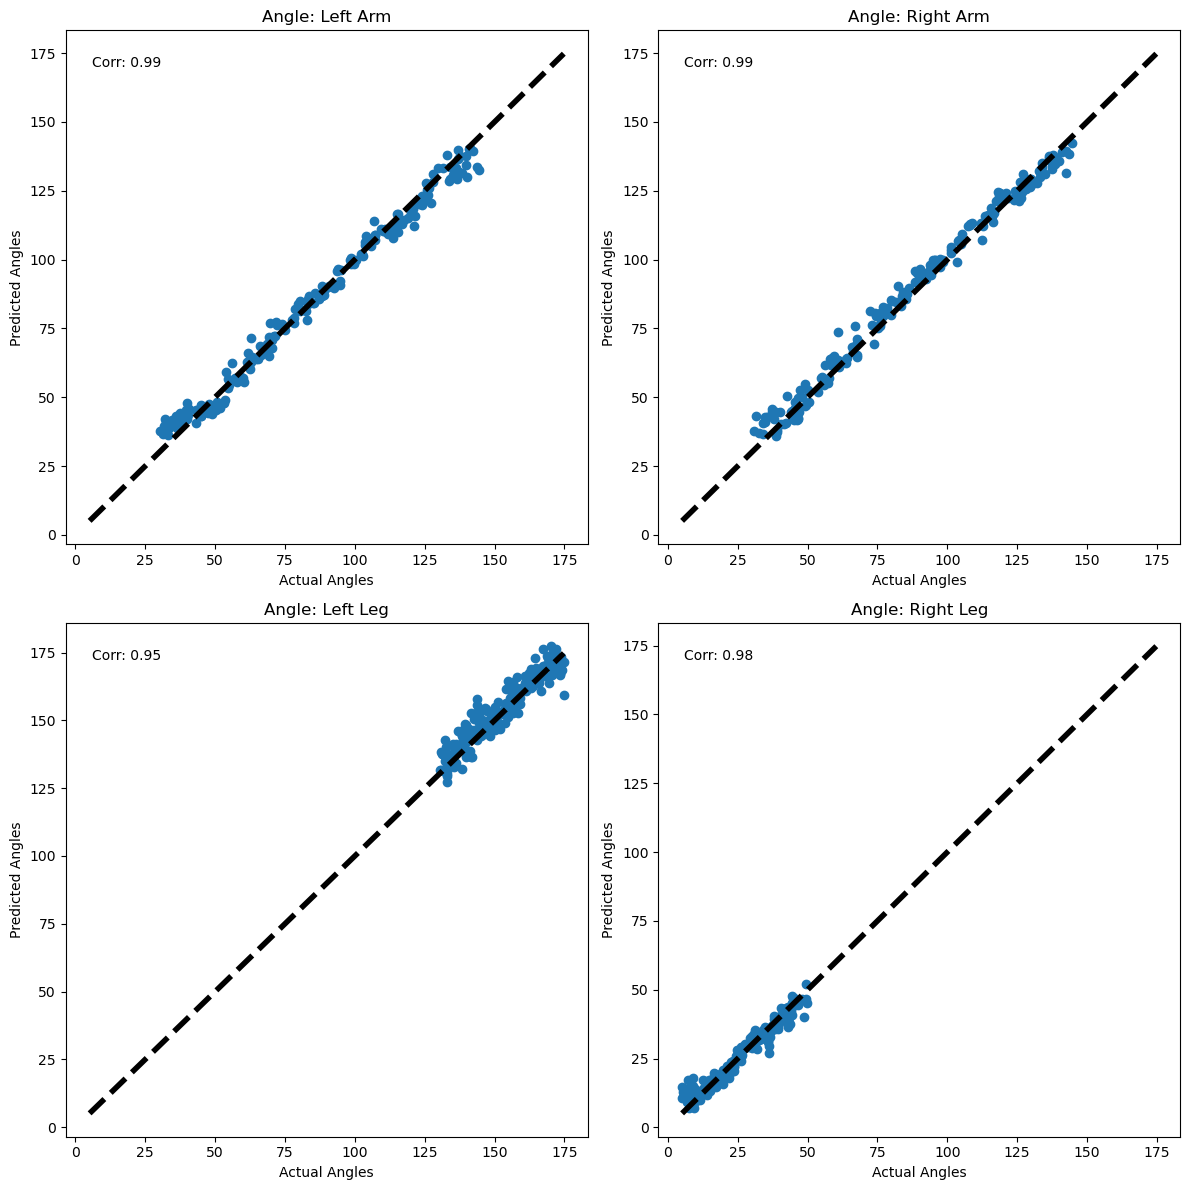

In [9]:
y_pred = model.predict(X_test)

# Plot the predictions against the actual values
def plot_predictions(y_true, y_pred, angle_names):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs = axs.ravel()
    
    for i in range(4):
        axs[i].scatter(y_true[:, i], y_pred[:, i])
        axs[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
        axs[i].set_title(f'Angle: {angle_names[i]}')
        axs[i].set_xlabel('Actual Angles')
        axs[i].set_ylabel('Predicted Angles')
        
        # Calculate the correlation coefficient for each angle
        corr_coef = np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1]
        axs[i].text(0.05, 0.95, f'Corr: {corr_coef:.2f}', transform=axs[i].transAxes, 
                    verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

angle_names = ['Left Arm', 'Right Arm', 'Left Leg', 'Right Leg']
plot_predictions(y_test, y_pred, angle_names)

Now we have a body equipped with a represntation capability. Let's get started on the sensorimotor play!

In the play, our stickbaby will first generate an intention of move as preference.


In [21]:
# generate a move intention as preference state for every playing
def generate_intention_angles():
    return {
        'left_arm': np.random.uniform(30, 145),
        'right_arm': np.random.uniform(30, 145),
        'left_leg': np.random.uniform(130,175),
        'right_leg': np.random.uniform(5, 50)
        }

def array(angles):
    # Ensure that the angles dictionary is converted to a numpy array
    angles_array = np.array([[angles['left_arm'], angles['right_arm'], 
                              angles['left_leg'], angles['right_leg']]])
    return angles_array


# Define the observation space as a continuous space with angles for each limb
def  observation(image_paths):
    image = load_and_preprocess_images(image_paths)
    obs_angles = model.predict(image)
    return obs_angles

# This function simulates the execution of a movement with a certain level of variance
def execution_var(intention, var):
    execution = {}
    for limb, angle in intention.items():
        execution[limb] = np.random.uniform(angle - var, angle + var)
    return execution

# Generate an image of body based on the provided angles
def image_body(i,j,angles):
    """
    Draw a stickman on the given axis.

    Parameters:
    - ax: Matplotlib axis to draw on.
    - head_coords: Coordinates of the head (x, y).
    - limb_lengths: Dictionary with lengths of limbs (arms and legs).
    - angles: Dictionary with angles (in degrees) of limbs.
    """
    # Calculate limb positions based on angles and lengths
    def get_limb_coords(start, length, angle):
        return (start[0] + length * np.cos(np.radians(angle)),
                start[1] + length * np.sin(np.radians(angle)))

    # Generate a random stickman
    fig, ax = plt.subplots()
    limb_lengths = {'arm': 1.5, 'leg': 2.5, 'body': 3}
    head_coords = (5, 10)
    # Draw the head
    head_radius = 0.5
    head_circle = plt.Circle(head_coords, head_radius, fill=True, color='black')
    ax.add_artist(head_circle)
    # Body (from head center to body center)
    body_length = limb_lengths['body']
    body_bottom = (head_coords[0], head_coords[1] - (head_radius + body_length))
    ax.plot([head_coords[0], body_bottom[0]], [head_coords[1], body_bottom[1]], 'k-')
    
    # Arms
    left_arm_angle = angles['left_arm']
    right_arm_angle = angles['right_arm']
    left_arm_end = get_limb_coords(body_bottom, limb_lengths['arm'], left_arm_angle + 90)
    right_arm_end = get_limb_coords(body_bottom, limb_lengths['arm'], right_arm_angle - 90)
    ax.plot([body_bottom[0], left_arm_end[0]], [body_bottom[1] + 1.5, left_arm_end[1]], 'k-')
    ax.plot([body_bottom[0], right_arm_end[0]], [body_bottom[1] + 1.5, right_arm_end[1]], 'k-')
    
    # Legs
    left_leg_angle = angles['left_leg']
    right_leg_angle = angles['right_leg']
    left_leg_end = get_limb_coords(body_bottom, limb_lengths['leg'], left_leg_angle + 90)
    right_leg_end = get_limb_coords(body_bottom, limb_lengths['leg'], right_leg_angle - 90)
    ax.plot([body_bottom[0], left_leg_end[0]], [body_bottom[1], left_leg_end[1]], 'k-')
    ax.plot([body_bottom[0], right_leg_end[0]], [body_bottom[1], right_leg_end[1]], 'k-')

    # Set limits and aspect
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 15)
    ax.set_aspect('equal')
    image_path = f'performance/performance_{i}_{j}.png'
    plt.axis('off')
    plt.savefig(os.path.join(image_path), bbox_inches='tight')
    plt.close(fig)

    return image_path


#### Variational free energy

Let's first focus on the definition of variational free energy. This section is based on Chapter 2 of the textbook "Active Inference: The Free Energy Principle in Mind, Brain, and Behavior," published by MIT Press in 2022.

The variational free energy $F$ can be calculated in three ways, the first is $$F[Q, y] = -\mathbb{E}_{Q(x)} \left[ \ln P(y, x) \right] - H[Q(x)]$$ Here, $Q$ represents the approximate posterior, and $y$ is the observed data.  This formula reflects the original meaning of 'free energy' in the context of physics and chemistry, which refers to the amount of work that a system can perform. As defined by Helmholtz, $A = U - TS$ where U is the internal energy of the system, and TS is the product of temperature and entropy. Correspondingly, the first term in the right-hand side, negative expectation of natural log of joint distribution of latent state $x$ and observation $y$ under the explanation $Q(x)$, is viewed as the energy term, reflecting how well the posterior explains observation. Just as lower energy means a more stable system, a lower energy term here means a better explanation. The second term on the right-hand side is the entropy of the approximate posterior. A higher entropy indicates a more peaked and certain distribution of $Q(x)$. A system tends to reach an equilibrium state spontaneously, as do active inference systems. Therefore, the optimal posterior should provide a good explanation of the observations while maintaining high uncertainty (according to the minimum free energy principle and the maximum entropy principle).

The second expression is $$F[Q, y] = D_{KL}[Q(x) \| P(x)] - \mathbb{E}_{Q(x)} \left[ \ln P(y | x) \right]$$ The first term on the right-hand side is the KL divergence between the approximate and the prior distributions, representing the complexity of the explanation; the lower it is, the better. The second term is the expected log-likelihood with respect to $Q(x)$, representing the accuracy of the explanation. Therefore, the most accurate posterior belief with the minimal free energy is that which has the highest accuracy and the lowest complexity.

The third expression is $$F[Q, y] = D_{KL}[Q(x) \| P(x | y)] - \ln P(y)$$ The first term on the right-hand side is the KL divergence between the approximate and the accurate posterior distributions. The second term is the negative natural logarithm of the evidence, representing the strength of the evidence, also known as the surprise or surprisal. This line underscores the objective of active inference: to find an approximate posterior that is as close as possible to the exact posterior, highlighting the nature of free energy as an upper bound on surprise.

 As described in our article, decrease free energy is felt as pleasure, and increased as unpleasure. That is, one shall have an expectation of free energy the sensorimotor play would produce. Notably, this expectation is not the expected free energy in the current context active inference, but rather a 'metacognition', an insight on their ability. Thus the expectation is modelled as the free energy of free energy. At every playing, the stickman generates an expectation on the divergence between his intention and performance (priors), and the monitored real divergence is dealt as an observation. In the imaginary identification, the stickman is identified with an Gestalt body, an ideal-ego, and an narcissistic subject, so the prior is nearly zero. Interestingly, here exists the essential struction of the identification as a misidentification -- as Lacan says, misidentification is not ignorance, but a organsization of affirmations and negations, and there must be knowledge of what there is to misidentify (posterior) behind his misidentification (prior).

In [24]:
from pymdp.maths import spm_log_single as log_stable

# Calculate KL divergence
def kl_divergence(a, b):
  """ Compute the Kullback-Leibler divergence between two 4-D continuous distributions"""
  kl_div = 0
  for i in range(4):
     kl_div += np.abs(log_stable(a[0][i]) - log_stable(b[0][i])) * a[0][i]
  return kl_div

# Get approximate posterior
def infer_states(observation, prior): 
    # Here we assume that the likelihood is represented by a Gaussian centered around the observation
    # and the prior is also Gaussian. We are going to compute the mean of the posterior distribution.
    # In a more complex model, these could be parameters that are passed to the function.
    likelihood_variance = 1.5
    prior_variance = 1
    
    # Compute the precision (inverse of variance)
    likelihood_precision = 1 / likelihood_variance
    prior_precision = 1 / prior_variance
    
    # Compute the precision-weighted observations and priors
    weighted_observation = observation * likelihood_precision
    weighted_prior = prior * prior_precision
    
    # Compute the sum of precisions
    total_precision = likelihood_precision + prior_precision
    
    # Compute the precision-weighted mean, which is the mean of the posterior distribution
    qx = (weighted_observation + weighted_prior) / total_precision
    
    return qx

def VFE(kl):
   
   complexity = np.abs(log_stable(kl)-log_stable(1.5)) * kl
   accuracy = - log_stable(0.9)
   F = complexity + accuracy

   return F

def kl_kl (a,b):
   return np.abs(log_stable(a)-log_stable(b)) * a

def update_certainty(cert,F):
   cert = (cert + F) / 2
   return cert


def plot_pleasure(pleasure_list, lable):
    plt.figure(figsize=(10, 5))
    plt.plot(pleasure_list)
    plt.xlabel('Time Step')
    plt.ylabel(lable)
    plt.legend()
    plt.grid(True)
    plt.show()


In [31]:
# define baseline (un)certainty
certainty = 200

for _ in range(1000):
    intention = array(generate_intention_angles())
    obser = array(generate_intention_angles())
    div1 = kl_divergence(intention,obser)
    div2 = kl_kl(div1,1)
    certainty = update_certainty(certainty, div2)

print(certainty)

pleas = []
unple = []
var = 50
for i in range(50):
    var = var * 0.90
    for j in range(20):

        #firstly, get a motor intention
        intention = generate_intention_angles()
        #then execute it with premature motor functions (var=20)
        execution = execution_var(intention, var)
        #observe the execution "from outside" using the CNN model 
        image_path = image_body(i,j,execution)
        obs = observation([image_path])
        prior = array(intention)
        qx = infer_states(np.array(obs), prior)
        kl = kl_divergence(np.array(qx),np.array(prior))
        vfe = VFE(kl)
        pleasure = certainty - vfe
        certainty = update_certainty(certainty, vfe)
        pleas.append(pleasure)
        unple.append(vfe)

494.7233480831195
1/1 [==============================] - 0s 164ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


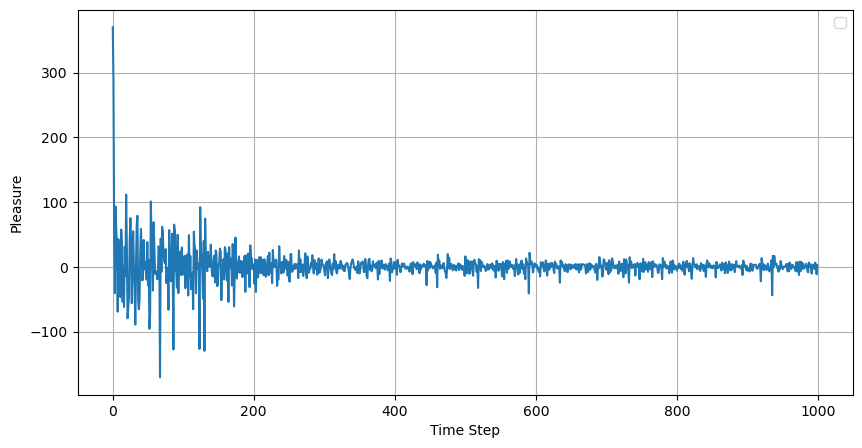

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


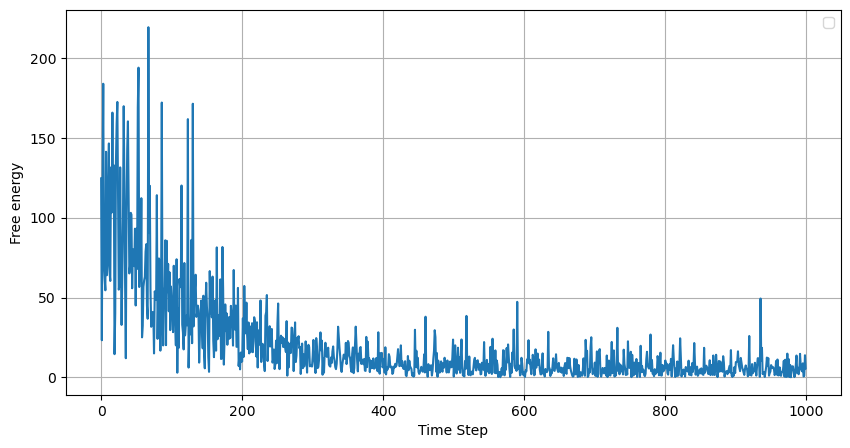

In [32]:
plot_pleasure(pleas, 'Pleasure')
plot_pleasure(unple, 'Free energy')